In [1]:
%load_ext autoreload
%autoreload 2

from model_utils import train_model, split_data, split_branches
from config import Config
import json
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
import os
import datasets
import torch
import transformers
from model_manager import ModelManager

In [2]:
seed = random.randint(0, 2 ** 32 - 1)
random.seed(seed)
datasets.logging.set_verbosity(datasets.logging.ERROR)
# Tell pytorch to run this model on the GPU.
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
# device_name = "cpu"
device = torch.device(device_name)
print(f"Will use {device_name} for training with seed: {seed}")

Will use cuda:0 for training with seed: 2584235038


In [3]:
split_data(os.path.join(Config.work_dir, "awsw_story_input.txt"))

In [4]:
config = {
    "model_name": "EleutherAI/gpt-neo-125M",
    "lr": 6e-4,
    "warmup_factor": 0,
    "scheduler": "polynomial_decay_schedule_with_warmup",
    "lr_end": 2e-6,
    "power": 0.6,
    #"freeze_layer_rate": 1e-4,
    "freeze_from_steps": -1,
    "seed": seed,
    "num_epoch": 50,
    "to_freeze_count": 150
}

optuna_result_attachement = {
    'lr': 0.001,
    'scheduler': 'cosine_schedule_with_warmup',
    'to_freeze_count': 155,
    'warmup_factor': 5
}
config.update(optuna_result_attachement)
config

{'model_name': 'EleutherAI/gpt-neo-125M',
 'lr': 0.001,
 'warmup_factor': 5,
 'scheduler': 'cosine_schedule_with_warmup',
 'lr_end': 2e-06,
 'power': 0.6,
 'freeze_from_steps': -1,
 'seed': 2584235038,
 'num_epoch': 50,
 'to_freeze_count': 155}

In [5]:
train_results = {}
train_model(config, train_results, device = device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Dataset demo snapshot:
<d><scn>black<msg>Br "The rules are simple. We both get a round, then we wait a few moments until the next one so the effects can kick in. Whoever gives up first loses."<|endoftext|><p><msg>c "So you're saying this is a date?"<|endoftext|><p><msg>c "The question is whether you or I would find those reasons good, too."<|endoftext|><d><scn>black<msg>Ry "I'll be just a minute."<|endoftext|><d><scn>black<msg>m "I was getting tired. I could hear Bryce
's voice, but I could not make out the individual words anymore. I decided to rest my eyes, just for a little bit..."<|endoftext|><p><msg>c "Flooding?"<|endoftext|>Human Matters Consultant" would be more appropriate."<|endoftext|><p><msg>c "Sounds like you've got it all figured out already."<|endoftext|><d><scn>park3<msg>Em "I see."<|endoftext|><d><scn>facin3<msg>Lo "I'm just fetching some equipment for my roommate. He's in the middle of an experiment and really needs this stuff."<|endoftext|><
[0] set freeze_part_layers

Step,Training Loss
52,3.855300
104,2.917700
156,2.601100
208,2.417700
260,2.338000
312,2.257900
364,2.179400
416,2.143200
468,2.100600
520,2.108000


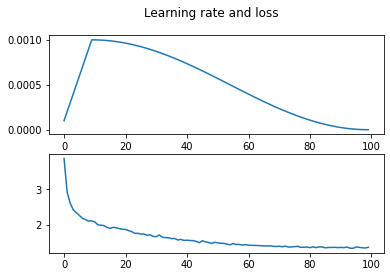

In [6]:
fig, axs = plt.subplots(2)
fig.suptitle('Learning rate and loss')
axs[0].plot(train_results['learning_rate_history'])
axs[1].plot(train_results['loss_history'])

# Testing

We created a few past (for context) + present prompts (player input) and see the different reactions. This way, we can test the models across different iterations.

In [7]:
train_results['model'].eval()
model_manager = ModelManager(model=train_results['model'], tokenizer=train_results['tokenizer'])

In [8]:
prompts = [
    ('<p><msg>c "Hey Remy!"<d><msg>Ry "Hey!"', "How are you?"),
    ('<p><msg>c "I was with Lorem today."<d><msg>Ad "Very nice."', "What do you think of Lorem?"),
    ('<p><msg>m "In Tatsu park, Adine and I sat down."', "Oh my god, Adine. What is this?"),
    ('<p><msg>m "I sat down on a chair in Anna\'s lab."', "What will we do here?"),
]

for (past, prompt) in prompts:
    reply = model_manager.say(past, prompt)
    print(f"Prompt: {prompt}\nReply: {reply}\n\n")

Prompt: How are you?
Reply: Ry "I'm fine."<p><msg>c "I'm fine."<d><msg>c "I'm fine."<d><msg>c "I'm fine."<d><msg>c "I'm fine."<d><msg>c "I'm fine."<d><msg>c "I'm fine."<d><msg>c "I'm fine."<d><msg>c "I'm fine."<


Prompt: What do you think of Lorem?
Reply: Ad "I think he's a very nice person."<p><msg>c "I think he's a very nice person."<d><msg>c "I think he's a very nice person."<p><msg>c "I think he's a very nice person."<d><msg>c "I think he's a very nice person."<d><msg>c "I think he's


Prompt: Oh my god, Adine. What is this?
Reply: Adine's eyes widened with disbelief.<d><scn>cafe<msg>Adine looked around the room, seemingly lost in thought.<d><scn>cafe<msg>Adine seemed genuinely impressed.<d><scn>cafe<msg>Adine seemed genuinely impressed.<d><scn>cafe<msg>Adine seemed genuinely impressed.<d><scn>c


Prompt: What will we do here?
Reply: black<msg>An "I sat down on a chair in Anna's lab."<d><scn>black<msg>An "I sat down on a chair in Anna's lab."<d><scn>black<msg>An "I sat down on a c

# Sampling test

Which combination is the best?

In [9]:
for i in range(100):
    torch.manual_seed(80085)
    top_k = random.randint(0, 100)
    top_p = round(random.uniform(0, 1), 2)
    for (past, prompt) in prompts:
        reply = model_manager.say(past, prompt, top_k = top_k, top_p = top_p)
        print(f"[Test {i + 1} top_k: {top_k}, top_p: {top_p}] -> Prompt: {prompt}\nReply: {reply}\n")
    print("-------------")

[Test 1 top_k: 37, top_p: 0.33] -> Prompt: How are you?
Reply: Ry "I'm fine."<p><msg>c "You too?"<d><msg>c "I'm fine."<d><msg>c "I'm fine."<d><msg>c "I'm fine."<d><msg>c "I'm fine."<d><msg>c "I'm fine."<d><msg>c "I'm fine."<d><msg>c "I'm fine."<d

[Test 1 top_k: 37, top_p: 0.33] -> Prompt: What do you think of Lorem?
Reply: Ad "He was very smart, very smart, very smart, very smart, very smart, very smart, very smart, very smart, very smart, very smart, very smart, very smart, very smart, very smart, very smart, very smart, very smart, very smart, very smart, very smart, very smart, very smart, very smart, very smart, very smart, very smart, very smart, very

[Test 1 top_k: 37, top_p: 0.33] -> Prompt: Oh my god, Adine. What is this?
Reply: Adine's eyes widened with disbelief.<d><scn>cafe<msg>Adine looked around the room."<d><scn>cafe<msg>Adine looked around the room."<d><scn>cafe<msg>Adine looked around the room."<d><scn>cafe<msg>Adine looked around the room."<d><scn>cafe<

[Test 1 top_

In [10]:
print("What to say?")
print(generate_dragon_reply("", input()))

What to say?


NameError: name 'generate_dragon_reply' is not defined